# ASTROGET

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20231012' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'astroget', 'NOIRlab']

This notebook demonstrates using the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

This notebook uses the **_Alpha_ release** of the pixel-level cutout service. The Alpha release only provides the capability to retrieve one cutout per web service call. This release should be considered as a basic starting point. We do not think it is ready for public release.  Using this release, a user can make multiple web-service calls to retrieve multiple cutouts. But since each web-service call has significant overhead, our expectations are that the number of cutouts retrieved by a user will be 1-200 (not thousands).

A **_Beta_ release** is forthcoming.  The Beta release will allow retrieval of a large batch of cutouts in one or two web service calls. 

## Table of contents
* [Goals & Summary](#goalssummary)
* [Imports and setup](#imports)
* [Discover Images](#discover)
* [Get HDU](#gethdu)
* [Get cutout of object](#cutout)
* [Generate photo album](#album)
* [Find all Messier objects](#messier)
* [Save Messier snapshots](#save_album)

<a class="anchor" id="goals"></a>
## Goals & Summary 
Demonstrate the use of the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/). 
- Discovery: Search for matching metadata and return metadata records.
- Find images containing regions of sky (SIA)
- Retrieve images
  + Full FITS file
  + Single HDU of FITS file
  + Cutout of rectangular region of one HDU of a FITS file (as a new FITS file)


<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
import os.path
from importlib import reload
from collections import defaultdict
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Suppress astropy warnings such as:
# WARNING: The following header keyword is invalid or follows an unrecognized ...
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install the most recent version of the `astroget`:
*NOTE: After installing the most recent version, please restart your kernel.*

In [33]:
#!pip install astroget==.0.4a2.dev8    # A specific version 
#!pip install -upgrade astroget        # Latest released version
#!pip install --pre -upgrade astroget   # Lastest pre-released version

# Uncomment next line to load ASTROGET from local current version of software.
! pip install --pre --upgrade ../..

Processing /home/pothiers/sandbox/astroget
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for astroget: filename=astroget-0.0.4a2.dev9-py3-none-any.whl size=323701594 sha256=0cc68b2eae6fb8eb23b7adb8f837325248f5ce78a55f192823a52915377dbcb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-tg7fb33s/wheels/db/f5/81/f8567d8b9183e27b58f39e09c64a7e76e7ddf682313fc7caf2
Successfully built astroget
  Attempting uninstall: astroget
    Found existing installation: astroget 0.0.4a2.dev9
    Uninstalling astroget-0.0.4a2.dev9:
      Successfully uninstalled astroget-0.0.4a2.dev9


In [34]:
import astroget.client
from astroget.utils import tic,toc
reload(astroget.client)

<module 'astroget.client' from '/home/pothiers/sandbox/astroget/venv/lib/python3.10/site-packages/astroget/client.py'>

In [35]:
print(f'Run started: {str(datetime.now())}')
# Server used must support client.cutout() method !!!
#server='https://astroarchive.noirlab.edu'     # Public server, HDUs>=408,118,252 Files>=18,731,991
#server='https://marsnat1-pat.csdc.noirlab.edu' # Test Server,  HDUs>=26,246,808  Files>=711,608
server='http://localhost:8060'                # Dev Server,    HDUs>=1,216
client = astroget.client.CsdcClient(url=server, show_curl=True)
client

Run started: 2023-09-15 10:03:07.528122


astroget_vers=0.0.4a2.dev9, api_vers=6.0, url=http://localhost:8060, verbose=False, show_curl=True, connect_timeout=3.05, read_timeout=300.0

# Basic Use of `astroget` for Cutouts
- Discover list of HDUs that contain pixels we want
  + get/display some metadata in pandas
  + retrieve/display a full matching HDU
- Cutout from HDU and display
- Cutout subimages from multiple HDUs and save FITS (appropriately named)

<a class="anchor" id="discover"></a>
## Find image/HDU of an object
Get position from name. Use additional constraints on the FITS files selected.
Display one of them.

Each HDU record contains `ra` and `dec` fields. Each of those is a RANGE. The Target for our cutout is given by an RA/DEC center and a size.  We can construct RA and DEC ranges for the Target (RA +/- width, DEC +/- height) We want only the HDUs that completely contain the Target. This kind of query can be done against our PostgreSQL 13 database using a "@>" ("contains") range operator.

   E.G. *ra @> target_ra*

Unfortunately, the syntax in FIND does not current support this. Fortunately, VOHDU does!

In [6]:
# Discover image(s) of object using VOHDU
#fname='/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_050615_oow_r_v1.fits.fz'
#obj_name = 'M65' #65,(77,96)
obj_name = 'M54'  # ingested into DEV
obj_coord = SkyCoord.from_name(obj_name)
ra = obj_coord.ra.degree
dec = obj_coord.dec.degree

# default search using Overlap (essentially Postgres "&&" range operator)
# Use very small size to approximate "obj center in HDU"
#search_size = 0.0001 # radius in degrees
search_size = 0.05

In [7]:
print(f'We will search {client.find(count=True,filerec=False).records[0]["count"]:,} HDUs.')

curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["md5sum"], "search": []}' 'http://localhost:8060/api/adv_search/find/?limit=500&rectype=hdu&count=y'
We will search 1,216 HDUs.


In [8]:
# prod_type=image
# proc_type=stack,stacked
found = client.vohdu((ra,dec), search_size,  # position=(ra,dec), size(in decimal degrees)
            instrument='decam', obs_type='object', proc_type='instcal',
            VERB=3, limit=None, verbose=False)

assert found.count > 0, 'Must have some objects to use CUTOUT'
print(f'Found {found.count} matches of object {obj_name} at position: ra,dec={(ra,dec)} using client.vohdu()')


Found 10 matches of object M54 at position: ra,dec=(283.763875, -30.479861) using client.vohdu()


In [9]:
hdus = [[rec[k] for k in ['md5sum','hdu_idx']] for rec in found.records]
targets = [[fid, hdu, ra, dec] for (fid,hdu) in hdus]
targets

[['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
 ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
 ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
 ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
 ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 36, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 43, 283.763875, -30.479861],
 ['b5cb08bbcf5c03e036b4f08f115e5773', 34, 283.763875, -30.479861],
 ['bb72cb6b898159456030c268a2b04028', 34, 283.763875, -30.479861],
 ['bc1db7e4587c3966a2a73b12c33236b8', 34, 283.763875, -30.479861]]

In [10]:
recidx = 0
rec = found.records[recidx]
print(f'Show 1 of {found.count} records. rec[{recidx}] = ')
print(f'{pf(rec)}')

md5 = rec['md5sum']
hduidx = rec['hdu_idx']
hduurl = rec['url']  

Show 1 of 10 records. rec[0] = 
{'archive_filename': '/archive-data/20210827/ct4m/2021A-0124/m54-1.fits',
 'dec_center': -30.43266,
 'exposure': 150.0,
 'file_caldat': '2021-08-27',
 'file_dateobs': '2021-08-28 04:05:06.81612+00',
 'file_release_date': '2021-08-27',
 'file_updated': '2023-08-24 23:46:49.486783+00',
 'filesize': 321442560,
 'filter': 'g DECam SDSS c0001 4720.0 1520.0',
 'hdu_idx': 36,
 'instrument': 'decam',
 'md5sum': '09a586a9d93a14a517f6d2e0e25f53da',
 'obs_type': 'object',
 'original_filename': '/data_local/images/DTS/2021A-0124/DECam_01026905.fits.fz',
 'proc_type': 'instcal',
 'prod_type': 'image',
 'proposal': '2021A-0124',
 'ra_center': 283.6985,
 'telescope': 'ct4m',
 'url': 'http://localhost:8060/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}


### API needs improvement; DISABLED
For FIND to be adequate for our needs, we need to be able to do something like:

`client.find(outfileds=[...], constraints={'hdu:ra': [target_ra, 'contains']})`

where 'ra' refers to the HDU RA field (defined as a range) and 'target_ra' refers to the range of RA we want in our cutout meaning numrange(min_target_ra, max_target_ra)

<a class="anchor" id="gethdu"></a>
## Get and Display one HDU

In [11]:
target = targets[0]
target

['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861]

HDU size in pixels = (4094, 2046)


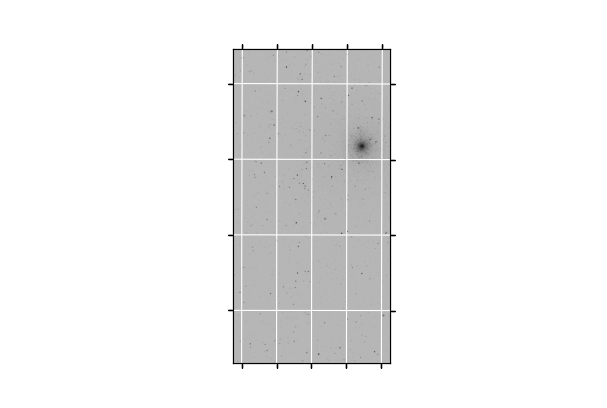

In [17]:
# Display cutout specified by first (zeroth) target.
target = ['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861]
(fid,hduidx,ra,dec) = target

# Make sure archive file is valid.  Normally this will always be true, but we 
# are recovering from a "mass storage" outage.
assert client.fitscheck(fid)['valid'], f"Invalid FITS file fid={fid}"
#'https://marsnat1-pat.csdc.noirlab.edu/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}
fname = client.getimage(fid,hdus=[0,hduidx+1])
header0 = fits.getheader(fname, 0) # hdu0=Primary, hdu1=image
image_data1, header1 = fits.getdata(fname, 1, header=True) # hdu0=Primary, hdu1=image
print(f'HDU size in pixels = {image_data1.shape}')

%matplotlib widget

wcs = WCS(header1)
plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

plt.imshow(image_data1, origin='lower', cmap='gray_r', norm='log')
plt.show()

<a class="anchor" id="cutout"></a>
## Cutout subimage from HDU

Get subimage centered at ra,dec=(283.763875, -30.479861) size 150. From image md5,hduidx=(09a586a9d93a14a517f6d2e0e25f53da, 36)
cutout url=http://localhost:8060/experimental/cutout/09a586a9d93a14a517f6d2e0e25f53da?ra=283.763875&dec=-30.479861&size=150&hduidx=37
curl -H 'Content-Type: application/json' 'http://localhost:8060/experimental/cutout/09a586a9d93a14a517f6d2e0e25f53da?ra=283.763875&dec=-30.479861&size=150&hduidx=37'
subimage as been cutout into local FITS file: subimage_09a586a9d93a14a517f6d2e0e25f53da_283_-30.fits


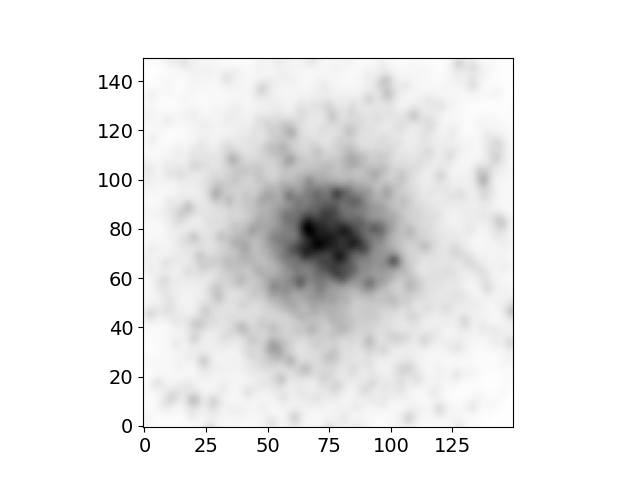

In [19]:

#subimage_size = 800
subimage_size = 150
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}. From image md5,hduidx=({md5}, {hduidx})')
# get FITS file
subimage = client.cutout(ra, dec, subimage_size, md5, hduidx, verbose=True)
print(f'subimage as been cutout into local FITS file: {subimage}')

image_data = fits.getdata(subimage)
plt.figure()
plt.imshow(image_data, origin='lower', cmap='gray_r')

In [20]:
subimage

'subimage_09a586a9d93a14a517f6d2e0e25f53da_283_-30.fits'

<a class="anchor" id="cutouts"></a>
# Get a BATCH of cutouts

In [21]:
print("Stopping execution to avoid long running search. "
      "Continue manually if you want.")
raise StopExecution

Stopping execution to avoid long running search. Continue manually if you want.


In [36]:
client

astroget_vers=0.0.4a2.dev9, api_vers=6.0, url=http://localhost:8060, verbose=False, show_curl=True, connect_timeout=3.05, read_timeout=300.0

<a class="anchor" id="discoverBatch"></a>
## Find image/HDU of an object
Get position from name. Use additional constraints on the FITS files selected.

In [39]:
# DEV targets
targets = [
                ['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
                ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
                ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
                ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
                ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861],
            ]
targets

[['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
 ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
 ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
 ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
 ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861]]

In [40]:
client.cutouts(150, targets, tarfile='notebook-cutouts.tar')

curl -H 'Content-Type: application/json' -d '[["09a586a9d93a14a517f6d2e0e25f53da", 37, 283.763875, -30.479861], ["2836105d9c941692f185a7e9ee902eab", 35, 283.763875, -30.479861], ["2d13e23d0cf2762890edaf9a179c3a1d", 37, 283.763875, -30.479861], ["3c8421ce38bf2a9112e3fbbb18405c33", 35, 283.763875, -30.479861], ["523c69cef368eaf24a66ac4010792490", 35, 283.763875, -30.479861]]' 'http://localhost:8060/experimental/cutouts/?size=150&background=0'


'From RunId=R-0160'

In [44]:
! tar --list -f notebook-cutouts.tar

MANIFEST.csv
cutout_0.fits
cutout_1.fits
cutout_2.fits
cutout_3.fits
cutout_4.fits


In [51]:
! tar --get -f notebook-cutouts.tar MANIFEST.csv
! tar --get -f notebook-cutouts.tar cutout_1.fits

In [52]:
import pandas as pd
pd.read_csv('MANIFEST.csv')  

,Cutout File,FileId,Hdu,RA,DEC,Archive File,Error
0,cutout_0.fits,09a586a9d93a14a517f6d2e0e25f53da,37.0,283.763875,-30.479861,/archive-data/20210827/ct4m/2021A-0124/m54-1....,False
1,cutout_1.fits,2836105d9c941692f185a7e9ee902eab,35.0,283.763875,-30.479861,/archive-data/20180523/ct4m/2018A-0159/m54-2....,False
2,cutout_2.fits,2d13e23d0cf2762890edaf9a179c3a1d,37.0,283.763875,-30.479861,/archive-data/20210702/ct4m/2021A-0124/m54-3....,False
3,cutout_3.fits,3c8421ce38bf2a9112e3fbbb18405c33,35.0,283.763875,-30.479861,/archive-data/20180428/ct4m/2018A-0159/m54-4....,False
4,cutout_4.fits,523c69cef368eaf24a66ac4010792490,35.0,283.763875,-30.479861,/archive-data/20180428/ct4m/2018A-0159/m54-5....,False
5,run_id = 160,NaN,NaN,NaN,NaN,NaN,NaN


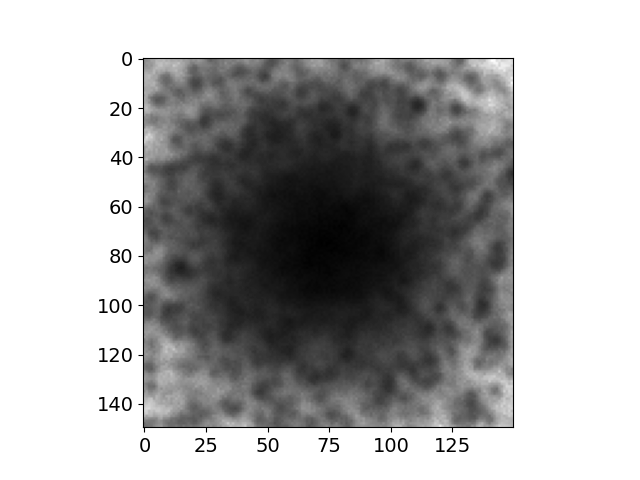

In [55]:
image_data = fits.getdata('cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

In [41]:
recidx = 0
rec = found.records[recidx]
print(f'Show 1 of {found.count} records. rec[{recidx}] = ')
print(f'{pf(rec)}')

md5 = rec['md5sum']
hduidx = rec['hdu_idx']
hduurl = rec['url']  

Show 1 of 10 records. rec[0] = 
{'archive_filename': '/archive-data/20210827/ct4m/2021A-0124/m54-1.fits',
 'dec_center': -30.43266,
 'exposure': 150.0,
 'file_caldat': '2021-08-27',
 'file_dateobs': '2021-08-28 04:05:06.81612+00',
 'file_release_date': '2021-08-27',
 'file_updated': '2023-08-24 23:46:49.486783+00',
 'filesize': 321442560,
 'filter': 'g DECam SDSS c0001 4720.0 1520.0',
 'hdu_idx': 36,
 'instrument': 'decam',
 'md5sum': '09a586a9d93a14a517f6d2e0e25f53da',
 'obs_type': 'object',
 'original_filename': '/data_local/images/DTS/2021A-0124/DECam_01026905.fits.fz',
 'proc_type': 'instcal',
 'prod_type': 'image',
 'proposal': '2021A-0124',
 'ra_center': 283.6985,
 'telescope': 'ct4m',
 'url': 'http://localhost:8060/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}


In [ ]:
# Some fields of all records
mykeys = {'archive_filename', 'md5sum', 'hdu_idx'}
[{k: rec[k] for k in mykeys} for rec in found.records]

Note: two HDUs match in m54-6.fits

<a class="anchor" id="cutoutBatch"></a>
## Cutout a batch of subimages corresponding to many HDUs

In [ ]:
subimage_size = 150
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}'
      f' from image many HDUs')
# get tarball of FITS files
targets = [[rec['md5sum'], rec['hdu_idx'], ra, dec] for rec in found.records]
url = client.cutouts(subimage_size, targets, wait=True, verbose=True)
print(f'Cutouts are available for download from {url}')

<a class="anchor" id="album"></a>
# Generate astronomy photo album
Given a list of astro objects, find images that contain them and extract a subimage of the object. We don't know how big the objects are so all subimages are the same size. That size might be too big or too small.

In [ ]:
print("Stopping execution to avoid long running loop. "
      "Continue manually if you want.")
raise StopExecution

<a class="anchor" id="messier"></a>
## Find All Images (HDUs)for Messier objects in the Astro Data Archive
For each object name: get its position and search full archive for HDUs that overlap a box around the object position. All 393 mil(26 mil) HDUs are searched.

In [ ]:
%%time
albumdir = os.path.expanduser('~/astro-album/')
search_size = 0.0001 # radius in degrees
subimage_size = 800 # square pixels

objs = defaultdict(list)
for n in range(1,110+1):
    name = f'M{n}'
    obj_coord = SkyCoord.from_name(name)
    ra = obj_coord.ra.degree
    dec = obj_coord.dec.degree
    
    found = client.vohdu((ra,dec), search_size, VERB=3, 
                        instrument='decam', obs_type='object', proc_type='instcal',
                        limit=None)
    print(f'Found {found.count} "{name}" objects',end='. ')
    print
    for rec in found.records:
        objs[name].append(rec)
files = set([(r['md5sum'],r['archive_filename']) for obrecs in objs.values() for r in obrecs])
print(f'\n\nFound at least one HDU for objects: {[k for k,v in objs.items() if len(v) > 0]}')

In [ ]:
badfiles = {'/net/archive/pipe/20130910/ct4m/2012B-0001/c4d_130911_034852_ooi_i_d2.fits.fz',
 '/net/archive/pipe/20160923/ct4m/2012B-0001/c4d_160924_064533_oow_r_v2.fits.fz',
 '/net/archive/pipe/20190607/ct4m/2019A-0305/c4d_190608_045632_ooi_g_v1.fits.fz',
 '/net/archive/pipeline/Q20150425/DEC15A/20150407/c4d_150410_033027_ooi_z_v1.fits.fz',
 '/net/archive/pipeline/Q20150617/DEC15A/20150611/c4d_150613_092917_ooi_g_v1.fits.fz',
 '/net/archive/pipeline/Q20150719/DEC15A/20150714/c4d_150715_071229_ood_g_v1.fits.fz',
 '/net/archive/pipeline/Q20150918/REQ13B/HETDEX/c4d_131215_034511_oow_Y_v2.fits.fz',
 '/net/archive/pipeline/Q20160104/DEC15B/20151229/c4d_151230_063527_ood_i_v1.fits.fz',
 '/net/archive/pipeline/Q20160105/DEC15B/20151229/c4d_151230_053314_ood_r_v1.fits.fz',
 '/net/archive/pipeline/Q20160302/DEC16A/20160225/c4d_160302_022120_oow_g_v1.fits.fz',
 '/net/archive/pipeline/Q20160907/DEC16B/20160831/c4d_160906_034258_oow_VR_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170107_080204_oow_z_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170107_081751_oow_u_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170108_081653_oow_u_v1.fits.fz'}

In [ ]:
len(badfiles), len(files)

<a class="anchor" id="save_album"></a>
## Save local subimages for all Messier objects we found
Store all FITS subimates in a single directory using a file name that contains the Messier object name.
Each `client.cutout()` call makes a web-service call which: reads the HDU image data and metadata, extracts the cutout into a new tempory FITS file that contains the original Primary HDU and Extension=1 HDU that contains the submage (with WCS), and streams the temporary file in the HTTP response.  The client reads the response and saves it to a local file.

In [ ]:
%%time
aa = '~/astro-album/'
albumdir = os.path.expanduser(aa)
count = 0
tic()
for name,v in objs.items():
    total = len(v)
    for idx,rec in enumerate(v):
        print(f'Create cutout for {name}[{idx}/{total}]', end='...')
        
        #!if name=='M2' and idx==3:
        #!    continue
        if rec['archive_filename'] in badfiles:
            print('skipped', end='...')
            continue

        obj_coord = SkyCoord.from_name(name)
        ra = obj_coord.ra.degree
        dec = obj_coord.dec.degree
        outfile = f'{albumdir}/subimage_{name}_{idx}.fits'
        try:
            client.cutout(ra, dec, subimage_size, 
                          #rec['url'], 
                          rec['md5sum'], rec['hdu_idx'],
                          outfile=outfile)
            count += 1
        except Exception as err:
            print(f'\nFailed cutout for {name}[{idx}]; {err}')
            continue
elapsed = toc()
print('All Done!\n')
print(f'Created and retrieved {count} cutouts in {elapsed:0.2f} seconds. ({count/elapsed:0.1f} cutouts/sec)') # 0.4
#!print(f'You might want to view all files {aa} in  with QFitsView and turn on "blink" to get a slide show.')
print(f'\nYou might want to view all files in {aa} with ds9 (SAOImageDS9) and turn on "blink" to get a slide show.'
      f'\n  EXAMPLES: '
      f'\n  ds9 {aa}*.fits -blink'
      f'\n  ds9 {aa}*.fits -blink interval 0.1 -blink  # one frame every 0.1 seconds\n'
     )

In [ ]:
aa = '~/astro-album/'

In [ ]:
!ds9 {aa}*.fits -blink interval 0.2 -blink